In [4]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

ImportError: this version of pandas is incompatible with numpy < 1.17.3
your numpy version is 1.16.2.
Please upgrade numpy to >= 1.17.3 to use this pandas version

In [1]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F

from nbeats_keras.model import NBeatsNet 
# from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')

ModuleNotFoundError: No module named 'nbeats_keras'

In [3]:
from data_processing import process_data

REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

production = pd.read_csv('palm_oil_data/production_good.csv')
rainfall = pd.read_csv('palm_oil_data/rainfall_good.csv')
area = pd.read_csv('palm_oil_data/area_good.csv')
RAINFALL_LAGS = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
PRODUCTION_LAGS = [13, 14, 15, 16, 17]
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)
ts = DATA['Johor'][0]
y = DATA['Johor'][1]
ts['date'] = ts.index
ts = ts[["Johor_Production", "date"]]
ts['value'] = ts['Johor_Production']
ts = ts.reset_index()
ts["time_idx"] = ts.index

ts

,index,Johor_Production,date,value,time_idx
0,1999-06-01,210.553,1999-06-01,210.553,0
1,1999-07-01,223.731,1999-07-01,223.731,1
2,1999-08-01,224.397,1999-08-01,224.397,2
3,1999-09-01,234.327,1999-09-01,234.327,3
4,1999-10-01,237.426,1999-10-01,237.426,4
...,...,...,...,...,...
215,2017-05-01,225.834,2017-05-01,225.834,215
216,2017-06-01,205.989,2017-06-01,205.989,216
217,2017-07-01,284.963,2017-07-01,284.963,217
218,2017-08-01,293.140,2017-08-01,293.140,218


In [3]:
# import pandas as pd
from nbeats_forecast import NBeats

data = pd.read_csv('data.csv')   
data = data.values        #univariate time series data of shape nx1 (numpy array)

model = NBeats(data=data, period_to_forecast=12)
model.fit()
forecast = model.predict()

ModuleNotFoundError: No module named 'nbeats_forecast'

In [4]:
data = ts.value       

NameError: name 'ts' is not defined

In [4]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
# data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
# data = ts
data["time_idx"] = data.index
data["series"] = data.index - data.index
data.head()

# data = ts

,series,time_idx,value,date
0,0,0,-0.000000,2020-01-01
1,0,1,-0.046501,2020-01-02
2,0,2,-0.097796,2020-01-03
3,0,3,-0.144397,2020-01-04
4,0,4,-0.177954,2020-01-05


In [7]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 15

training_cutoff = len(data) - 1 - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
val_dataloader

In [9]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)


tensor(0.0910)

In [10]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.01)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


C:\Users\m84200118\AppData\Roaming\Python\Python37\site-packages\pytorch_lightning\trainer\trainer.py:818: LightningDeprecationWarning: `trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.tune(train_dataloaders)` instead. HINT: added 's'
  "`trainer.tune(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.821     Total estimated model params size (MB)
Global seed set to 42
Finding best initial lr: 100%|██████████| 100/100 [00:21<00:00,  4.71it/s]Restoring states from the checkpoint file at c:\Users\m84200118\Documents\cs_5\forecasting\lr_find_temp_model.ckpt
Restored all states fro

suggested learning rate: 0.003981071705534973


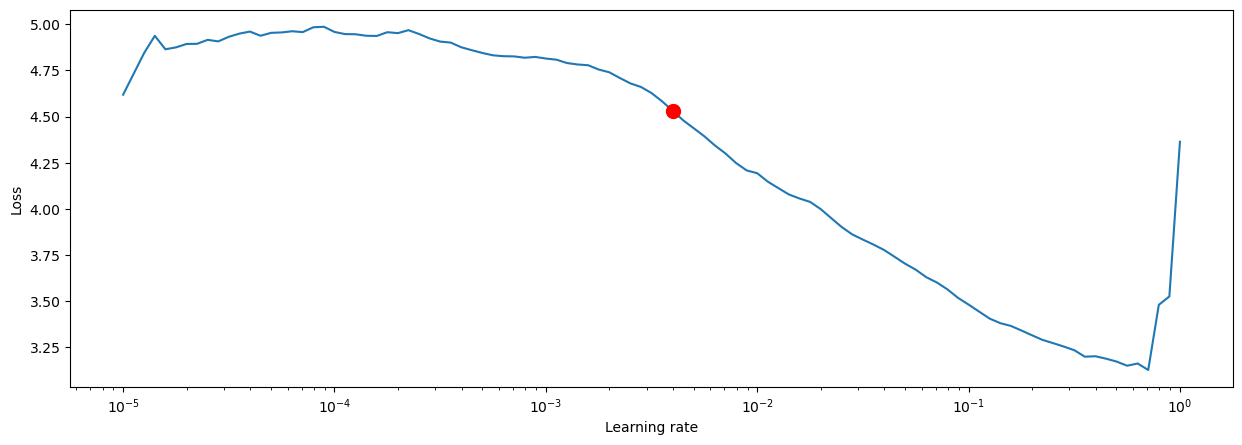

In [11]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()


In [12]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)


net = NBeats.from_dataset(
    training,
    learning_rate=4e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\m84200118\AppData\Roaming\Python\Python37\site-packages\pytorch_lightning\trainer\trainer.py:531: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.821     Total estimated model params size (MB)


Global seed set to 42


Epoch 4: 100%|██████████| 31/31 [00:12<00:00,  2.65it/s, loss=1.7, v_num=3, train_loss_step=1.650, val_loss=1.180, train_loss_epoch=1.550]


In [13]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)


In [14]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.5599)

In [35]:
from pytorch_forecasting.metrics import SMAPE
# calculate metric by which to display
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
# indices = mean_losses.argsort(descending=True)  # sort losses

# raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
# # show only two examples for demonstration purposes
# for idx in range(2):
#     best_model.plot_prediction(
#         x,
#         raw_predictions,
#         idx=indices[idx],
#         add_loss_to_title=SMAPE()
#     )


AttributeError: 'Output' object has no attribute 'ndim'

In [32]:
best_model.predict(val_dataloader)

tensor([[-4.9307, -5.0109, -5.0236, -5.0072, -5.0086, -5.0478, -5.1057, -5.1412,
         -5.1247, -5.0600, -4.9784, -4.9096, -4.8532, -4.7738, -4.6253]])

In [ ]:
raw_predictions, x = best_model.predict(, mode="raw", return_x=True)
for i in x:
    print(x)

AttributeError: 'dict' object has no attribute 'dataset'

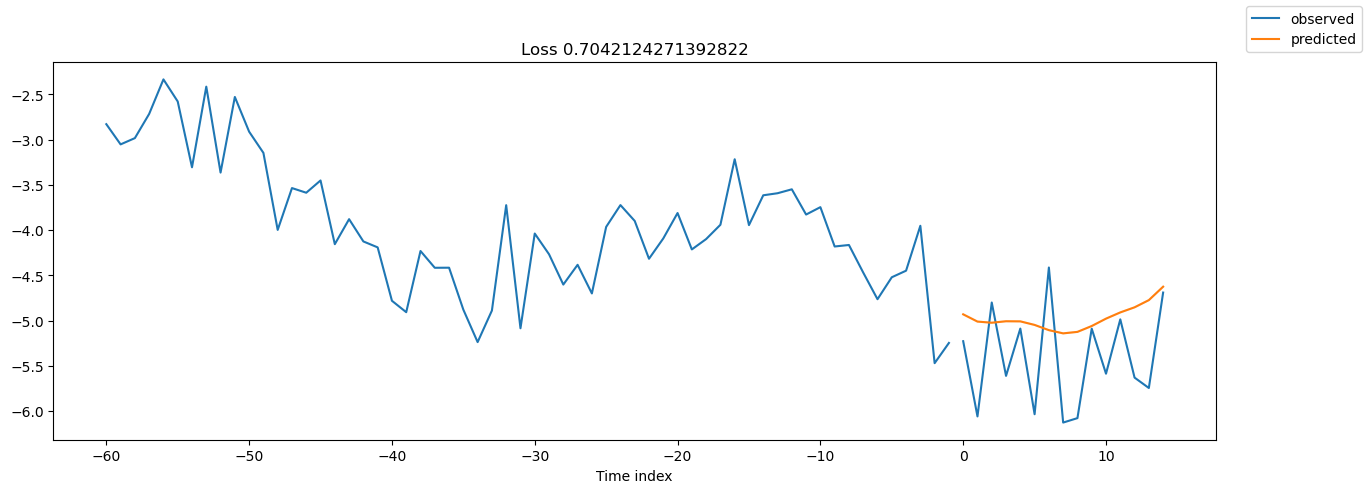

In [41]:
for idx in range(1):
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);
